### Background

Similarity search at a large scale with high-dimensional data suffers from the curse of dimensionality. One of the approaches proposed to tackle this problem is Approximate Nearest Neighbor (ANN), which boosts the search efficiency by finding an approximate set of nearest neighbors that are "close enough" to the query. One type of ANN search is called locality-sensitive hashing (LSH), which assigns the same or similar hash to vectors that are similar in the input space. 

There are various implementation of LSH. One of them is inspired by how the fruit fly's olfactory circuit encode odors, and shows both better performance and efficiency compared to conventional LSH (Dasgupta et al., 2017). 

### Question
Implement the Fly-LSH in a supervised manner to improve classification accuracies. 


### Part I Replicating Fly-LSH Results

#### 1.1 A brief summary of the Fly-LSH
Compared to conventional LSH, the Fly-LSH differs in three ways (Dasgupta et al., 2017, Fig.1):
1. The Fly-LSH uses sparse, binary random projections, whereas conventional LSH usually use dense, Gaussian random projections;
2. The Fly-LSH expands the dimensionality of the input after projection from the d-dimensional input space to the m-dimensional hash space (d << m), whereas conventional LSH reduces the dimensionality (d >> m);
3. The Fly-LSH sparsifies the higher-dimensionality representation by a Winner-Take-All (WTA) mechanism, whereas conventional LSH preserves a dense representation. 

All three differences lead to better performance and/or efficency of the Fly-LSH compared to conventional LSH. The first difference did not hurt performance, which is measured by the mean Average Precision (mAP), but boosted the search efficiency by a factor 20 (Dasgupta et al., 2017, Fig.2A). The second and third differences helped improve performance (Dasgupta et al., 2017, Fig.2B and Fig.3). 

#### 1.2 Implementation in Python 
My goal for this section is to replicate results in Fig.3 for the MNIST dataset (Dasgupta et al., 2017). 

[A Python implementation](https://github.com/dataplayer12/Fly-LSH) of the Fly-LSH is available from a follow-up paper (Sharma & Navlakha, 2018; [companion blog](https://medium.com/@jaiyamsharma/efficient-nearest-neighbors-inspired-by-the-fruit-fly-brain-6ef8fed416ee)). The code is very well-written and covers multiple algorithms and benchmarks. I managed to extract the Fly-LSH algorithm out of it and re-wrote everything in a non-OOP manner to pave the way for implementing Part II.

#### 1.3 Results

Comparison of mAP performance of Fly-LSH vs. conventional LSH from multiple sources is summarized in the figure below:

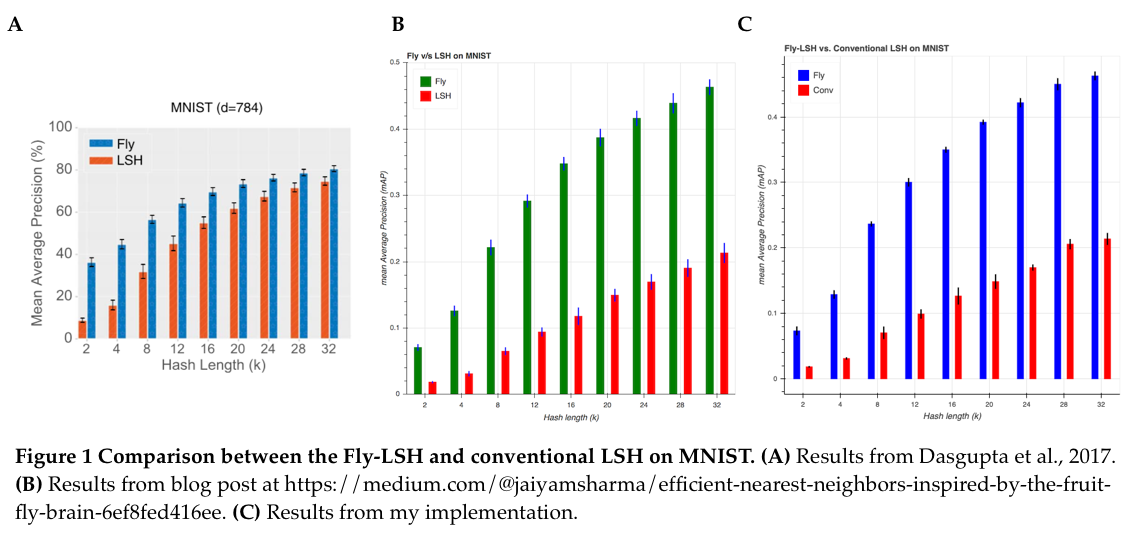

Results
1. mAPs of the Fly-LSH is roughly 3x bigger than that of conventional LSH (Fig. 1C); 
2. Results from my implementation matched that from the blog post (Fig. 1B and 1C), but together they don't match results from Fig.3 in Dasgupta et al., 2017 (Fig. 1A).
    - One possible cause of the mismatch could be the difference in mAP implementation. In Dasguptal et al., 2017, average precisions of true and predicted nearest neighbors are measured by the Euclidean distance between vectors, while in the [Python implementation](https://github.com/dataplayer12/Fly-LSH), they are measured by the Hamming distance. 
    - Another possibility is that WTA was implemented differently in the paper vs. in the blog post, but I don't have code from the paper to confirm that. 

### Part II Thoughts on Supervised Fly-LSH

**Here comes the interesting question: how can we implement the Fly-LSH in a supervised manner for classification tasks?**

A jump-start paper recommmended by Dr. Chua is the Sablayrolles et al., 2016 ([companion Python implementation](https://github.com/facebookresearch/supervised-hashing-baselines/blob/master/main.py)), so I read the paper first and found two lines of thought to implement the supervised version. 

#### 2.1 Design
The first option is to implement a classifier before LSH, as the authors did in the paper. Specifically, based on the companion Python code, they implemented a Logistic Regression classifier first, followed by an anti-sparse LSH from [FAISS](https://github.com/facebookresearch/faiss). The best mAP they can achieve with this implementation is around 42% (Sablayrolles et al., 2016, Table 1). 

However, I prefer to implement the other option first, which is to put a classifier after LSH, for a few reasons: 
- In LSH, input vectors with the same label would have the same or similar hash, which means we can easily group hashes based on their corresponding labels, and then calculate a representative hash for each label (details below). 
    - Similar idea is also mentioned in the paper where the authors state that "The experimental protocol consists in defining "similar" vectors as vectors from the same class. This protocol transforms the similarity search problem into a classification problem: the optimal way of performing the search is to classify the query and database vectors."
    - This line of thought also matches the one-versus-all (OvA) strategy in multiclass classification. In this paradigm, when it comes to classify an image, we compute the decision score (details below) from each classifier for that image and select the class with the highest score. 
- In Sablayrolles et al., 2016, the authors also found that, in the case of transfer learning, inserting the layer producing a compact code in the middle of the network leads to better accuracy (Table 4). In that study, the compact code is produced by Product Quantization (PQ) instead of LSH, so it worth trying putting a LSH mid-layer in the network and see how it works. 

#### 2.2 Implementation
Below are my primitive thoughts on how to implement the classifier: 
1. First, we group hashes by the label of their corresponding input vectors. These hashes are locality-sensitive, so hashes with the same label would be the same or similar to each other, and therefore we can compute a representative hash for each label based on certain similarity measures. For example, one of the simplest way to do this is to add up all the hashes with the same label in an element-wise manner, normalize each element by the number of hashes in the group, and then convert it to a binary vector by a pre-defined threshold. 
2. When it comes to classify an image, we compute its LSH first, and then compare its LSH to the representative hash of each label, measure their similarity (e.g. Hamming distance for binary vectors), and assign it to the most similar label. 

Now, I have to admit that it would take me a couple more days to customize a supervised Fly-LSH, partially because I am not yet familiar with the relevant tools like Tensorflow. Therefore, supervised.py is not finished yet, but rather shows the backbone of how I would implement it given more time. 

#### 2.3 Next steps
Compared to the studies in Sablayrolles et al., 2016, a few things we can do in the future are:
- For the classifier+LSH design, change the anti-sparse LSH in their paper to the sparse Fly-LSH and see if it improves performance; 
- For the LSH+classifier design, implement the sparse Fly-LSH in the mid-layer of the network, and compare its performance to that of the PQ+classifier deisgn. 

### References
1. Dasgupta S, Stevens CF, Navlakha S (2017) A neural algorithm for a fundamental computing problem. Science 358:793–796.
2. Sharma J, Navlakha S (2018) Improving Similarity Search with High-dimensional Locality-sensitive Hashing. arXiv cs.LG.
3. Sablayrolles A, Douze M, Jégou H, Usunier N (2016) How should we evaluate supervised hashing? arXiv cs.CV.

### Additional Resources
1. Wang J, Shen HT, Song J, Ji J (2014) Hashing for Similarity Search: A Survey. arXiv cs.DS.
2. [Benchmarks of approximate nearest neighbor libraries in Python](https://github.com/erikbern/ann-benchmarks)